# Dimension selection via Wasserstein distance

Supporting code for the paper titled [Discovering latent topology and geometry in data: a law of large dimension](https://arxiv.org/abs/2208.11665). Further details and any references in the notebook to theorems, assumptions, etc. can be found there. 

## Package load

In [1]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import ot

from scipy import linalg
from scipy import sparse
import scipy.sparse.linalg

/home/ag16115/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Functions

In [2]:
def pc_scores(X, r, return_eig = None):
    U, s, Vh = sparse.linalg.svds(X,k=r)
    idx = s.argsort()[::-1] 
    s = s[idx]
    Vh = Vh[idx,:]
    Y = X @ Vh.T
    if return_eig is not None:
        return Y, s
    else:
        return Y

In [3]:
def poly_kernel(Z,c,r):
    return (Z @ Z.T + c) ** r

In [4]:
def make_circle(n,x=0,y=0,r=1):
    s = np.random.uniform(low=0, high=2*pi, size=n)
    return np.vstack((r*np.cos(s) + x, r*np.sin(s) + y)).T

In [5]:
def wasserstein_dim_select(Y, split = 0.5, rmax = 50):
    n = Y.shape[0]
    train = round(n * split)
    rtry = int(np.min((train, rmax)))
    
    Ytrain = Y[:train,:]
    Ytest = Y[train:n,:]
    U, s, Vh = sparse.linalg.svds(Ytrain,k=rmax)
    idx = s.argsort()[::-1] 
    s = s[idx]
    Vh = Vh[idx,:]
    ws = []
    for r in range(1,rtry+1):
        P = Vh.T[:,:r] @ Vh[:r,:]
        Yproj = Ytrain @ P.T
        n1 = Yproj.shape[0]
        n2 = Ytest.shape[0]
        M = ot.dist(Yproj,Ytest, metric='euclidean')
        W1 = ot.emd2(np.repeat(1/n1,n1),np.repeat(1/n2,n2),M)
        ws.append(W1)
    return ws

# Introduction

When calculating the PC scores the dimension $r$ must be chosen which, in practice, is normally through a data-driven method as $r$ is unlikely to be known and may not be finite. The main aim of applying PCA is to suppress some noise and make high-dimensional inference possible but this usually comes at the cost of losing some signal -- this is the bias/variance trade-off of choosing dimension. This means that even if $r$ is known, the bias/variance trade-off may favour a lower one if the variance is high and similarly if the rank is infinite, the bias/variance trade-off may suggest a moderately low dimension. If possible, such as a supervised task, we suggest picking the dimension by cross-validation. However, we now explore the situation where we must pick a dimension purely from the data matrix $\mathbf{Y}$.

While there are existing methods out there, we suggest a new technique which is automatic, moderately scalable and sound in practice, comparatively we found the ladle method by Wei Luo and Bing Li to perform well except in scalability (an implementation in R can be found here: [GitHub for ladle method](https://github.com/WenlanzZ/dimension)).

<div class="alert alert-block alert-success">
    
***
**Algorithm** PCA dimension selection
***
    
**Input:**  data matrix $\mathbf{Y}\in\mathbb{R}^{n\times p}$.

* Split the data as $\mathbf{Y}^{(1)} := \mathbf{Y}_{1:\lceil n/2 \rceil, 1:p}$, $\mathbf{Y}^{(2)} := \mathbf{Y}_{(\lceil n/2 \rceil + 1): n, 1:p}$
* $r\in\{1,...,\min(n,p)\}$
    * Let $\mathbf{V}^{(1)} \in \mathbb{R}^{p\times r}$ denote the matrix of orthogonal eigenvectors associated with the $r$ largest eigenvalues of $\mathbf{Y}^{(1)\top}\mathbf{Y}^{(1)}$ 
    * Project  $\mathbf{Y}^{(1)}$ onto the linear span of  $\mathbf{V}^{(1)}$,  $\hat{\mathbf{X}}^{(1)} := \mathbf{Y}^{(1)} \mathbf{V}^{(1)} \mathbf{V}^{(1)\top}$
    * Compute Wasserstein distance $d_r$ between $\hat{\mathbf{X}}^{(1)}$ and $\mathbf{Y}^{(2)}$ (as point sets in $\mathbb{R}^p$)
    

**Output:** selected dimension $\hat r = \text{argmin } \{d_r\}$.
    
***
</div>

In words, we split the data into two, and for each $r$ we project the first half onto the $r$ principal eigenvectors --- the points remain $p$-dimensional, just constrained to an $r$-dimensional subspace. Next, we measure how much this projection step has brought the first half closer to the second, using the first Wasserstein distance. The $r$ achieving the lowest distance is selected. We implement this method below using a simulated data example when $r$ is finite and known.

In [11]:
n = 500
p = 750
sigma = 2

In [12]:
sizes = np.random.multinomial(n, [1/4]*4, size=1)[0]
Z = np.vstack((make_circle(sizes[0],0,1),make_circle(sizes[1],0,-1),make_circle(sizes[2],1,0),make_circle(sizes[3],-1,0)))
K = poly_kernel(Z, 1, 2)
Y = np.random.multivariate_normal(np.zeros(n),K+sigma**2*np.eye(n),size=p).T

In [13]:
ws = wasserstein_dim_select(Y,.6)

In [14]:
print(f'Dimension selected: {np.argmin(ws) + 1}')

Dimension selected: 6


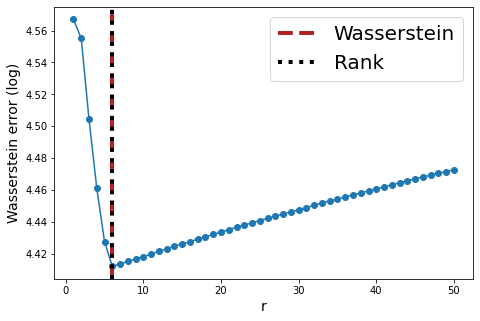

In [15]:
fig, ax = plt.subplots(1,1,figsize=(7.5,5))

ax.scatter(range(1,len(ws)+1), np.log(ws))
ax.plot(range(1,len(ws)+1),np.log(ws))
ax.axvline(x=np.argmin(ws) + 1,c ='firebrick',label = 'Wasserstein', linestyle='dashed',linewidth=4)
ax.axvline(x=np.linalg.matrix_rank(K),c ='black',label = 'Rank', linestyle='dotted',linewidth=4)
ax.legend(loc='upper right',prop={'size': 20})
ax.set_xlabel('r', fontsize=14);
ax.set_ylabel('Wasserstein error (log)', fontsize=14);

Therefore, the dimension selected coincides with the true rank. 